In [1]:
# Import all relevant libraries here:

import os
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import misc
import math
from numpy import r_
from skimage import io
from math import cos

image matrix size:  (539, 810)


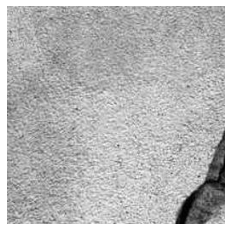

In [15]:
# Load in the image
f = io.imread('1.jpg', as_gray=True)
print('image matrix size: ', f.shape )

# Sample smaller size. NOTE, you can comment this out if you want to process the entire image
pos = 175
size = 256
f = f[pos:pos+size,pos:pos+size]

# Let's see how she looks!
plt.imshow(f, cmap=plt.cm.gray)
plt.axis('off')
plt.show()

In [16]:
# Initialize some parameters 

n = 8  # This will be the window in which we perform our DCT
sumd = 0 # INI value

# Create some blank matrices to store our data

dctmatrix = np.zeros(np.shape(f)) # Create a DCT matrix in which to plug our values :)
f = f.astype(np.int16) # Convert so we can subtract 128 from each pixel
f = f-128 # As said above
f2 = np.zeros(np.shape(f)) # This will be where the compressed image goes

# Let's preview our f values
f

array([[-128, -128, -128, ..., -128, -128, -128],
       [-128, -128, -128, ..., -128, -128, -128],
       [-128, -128, -128, ..., -128, -128, -128],
       ...,
       [-128, -128, -128, ..., -128, -128, -128],
       [-128, -128, -128, ..., -128, -128, -128],
       [-128, -128, -128, ..., -128, -128, -128]], dtype=int16)

To move forward, now we need to define the cosine function that will be plugged into both the DCT and IDCT functions

In [17]:
def cosp(i,j,n): # This is the funky cos function inside the DCT
    output = 0
    output = cos(((2*i)+1)*j*math.pi/(2*n))
    return output

In [18]:
def convolveDCT(f,n,u,v,a,b): # This convolve function compute DCT for nxn @ axb location
    sumd = 0                               #INI value
    for x in r_[0:n]:
        for y in r_[0:n]:
            u = u%n
            v = v%n
            sumd += f[x+a,y+b]*cosp(x,u,n)*cosp(y,v,n)
    # Now, need to perform the functions outside of the sum values    
    if u == 0: sumd *= 1/math.sqrt(2) 
    else: sumd *= 1
    if v == 0: sumd *= 1/math.sqrt(2)
    else: sumd *= 1
    sumd *= 1/math.sqrt(2*n)

    return sumd

In [19]:
# First we need to take into account our multiple nxn windows that jump across the image
for a in r_[0:np.shape(f)[0]:n]:
    for b in r_[0:np.shape(f)[1]:n]:
        # Below, compute the DCT for a given uxv location in the DCT Matrix
        for u in r_[a:a+n]:
            for v in r_[b:b+n]:
                dctmatrix[u,v] = convolveDCT(f,n,u,v,a,b)
# Let's take our first peek at the DCT 
np.around(dctmatrix)

array([[-1024.,    -0.,     0., ...,    -0.,     0.,     0.],
       [   -0.,    -0.,    -0., ...,    -0.,     0.,     0.],
       [    0.,    -0.,     0., ...,     0.,    -0.,     0.],
       ...,
       [   -0.,     0.,     0., ...,    -0.,     0.,     0.],
       [    0.,     0.,    -0., ...,     0.,     0.,    -0.],
       [    0.,    -0.,    -0., ...,     0.,    -0.,     0.]])

Text(0.5, 1.0, '8x8 DCTs of the image')

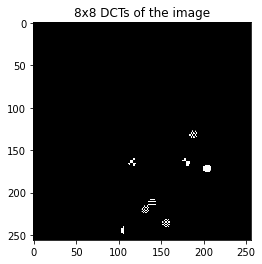

In [20]:
# Display entire DCT
plt.figure()
plt.imshow(dctmatrix,cmap='gray',vmax = np.max(dctmatrix)*0.01,vmin = 0)
plt.title("8x8 DCTs of the image")

Text(0.5, 1.0, '8x8 DCTs of the image')

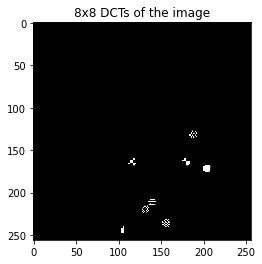

In [21]:
# Now, let's manipulate stuff a bit. Here, we will use a standard quant table to compress image
Quant = np.array([
  [16, 11, 10, 16, 24, 40, 51, 61],
  [12, 12, 14, 19, 26, 58, 60, 55],
  [14, 13, 16, 24, 40, 57, 69, 56],
  [14, 17, 22, 29, 51, 87, 80, 62],
  [18, 22, 37, 56, 68, 109, 103, 77],
  [24, 35, 55, 64, 81, 104, 113, 92],
  [49, 64, 78, 87, 103, 121, 120, 101],
  [72, 92, 95, 98, 112, 100, 103, 99]
])

# Convolve nxn sections across entire image to return    
# As factor variable increases, the image will compress even more
factor = 4
for a in r_[0:np.shape(f)[0]:n]:
    for b in r_[0:np.shape(f)[1]:n]:
        dctmatrix[a:a+n,b:b+n] = dctmatrix[a:a+n,b:b+n]/Quant*factor

        
# Let's take a look at how much it compressed the DCT...
# Display entire DCT
plt.figure()
plt.imshow(dctmatrix,cmap='gray',vmax = np.max(dctmatrix)*0.01,vmin = 0)
plt.title("8x8 DCTs of the image")

In [22]:
# Now we need to invert everything we have just accomplished! 
# Let's define our inverse function

def convolveIDCT(dctmatrix,n,x,y,a,b): # This convolve function compute DCT for nxn @ axb location
    sumd = 0                               #INI value
    for u in r_[0:n]:
        for v in r_[0:n]:
            val1 = 1
            val2 = 1
            x = x%n
            y = y%n
            if u == 0: val1 = 1/math.sqrt(2)
            if v == 0: val2 = 1/math.sqrt(2)
            sumd += dctmatrix[u+a,v+b]*val1*val2*cosp(x,u,n)*cosp(y,v,n)
    # Now, need to perform the functions outside of the sum values    
    sumd *= 2/n
    return sumd

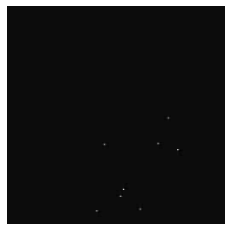

In [23]:
# And re run it to get our new compressed image! :)
# First we need to take into account our multiple nxn windows that jump across the image
for a in r_[0:np.shape(dctmatrix)[0]:n]:
    for b in r_[0:np.shape(dctmatrix)[1]:n]:
        # Below, compute the IDCT for a given x,y location in the Image Matrix
        for x in r_[a:a+n]:
            for y in r_[b:b+n]:
                f2[x,y] = convolveIDCT(dctmatrix,n,x,y,a,b)

f2 = f2 + 128 # Scale our values back to 0-255 so we can see it!

# Let's see how she looks AFTER Quantization!
plt.imshow(f2, cmap=plt.cm.gray)
plt.axis('off')
plt.show()